In [2]:
# Imports
import warnings
warnings.simplefilter("ignore")

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
#import seaborn as sns

import scipy
from scipy.stats import norm

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

#sns.set_style('darkgrid')
np.random.seed(42)
tf.random.set_seed(42)

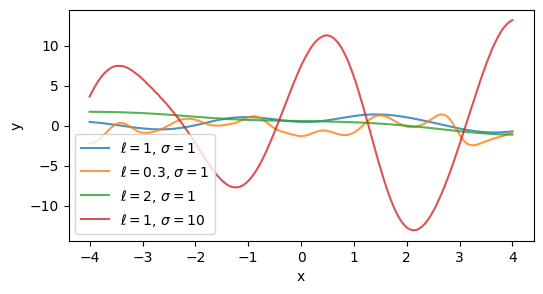

In [27]:
# Plot kernel matrix and samples of exponentiated quadratic

nb_of_samples = 150  # Number of test points.
nb_of_realizations = 1  # Number of function realizations
# Generate input points
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, nb_of_samples), 1)

# first model amplitude = 1., length_scale = 1
Σ1 = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=1.).matrix(X, X).numpy()
y1 = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ1, 
    size=nb_of_realizations).T

# second model amplitude = 1., length_scale = 0.3
Σ2 = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=0.3).matrix(X, X).numpy()
y2 = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ2, 
    size=nb_of_realizations).T

# third model amplitude = 1., length_scale = 2
Σ3 = tfk.ExponentiatedQuadratic(amplitude=1., length_scale=2.).matrix(X, X).numpy()
y3 = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ3, 
    size=nb_of_realizations).T

# forth model amplitude =10, length_scale=1
Σ4 = tfk.ExponentiatedQuadratic(amplitude=10., length_scale=1.).matrix(X, X).numpy()
y4 = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ4, 
    size=nb_of_realizations).T

# Start plotting
fig = plt.figure(figsize=(6, 3)) 
plt.plot(X, y1, alpha=0.8, label="$\\ell = 1$, $\\sigma = 1$")
plt.plot(X, y2, alpha=0.8, label="$\\ell = 0.3$, $\\sigma = 1$")
plt.plot(X, y3, alpha=0.8, label="$\\ell = 2$, $\\sigma = 1$")
plt.plot(X, y4, alpha=0.8, label="$\\ell = 1$, $\\sigma = 10$")
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title("")
plt.show()
#

In [3]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb, sigma, ls):
    # L2 distance (Squared Euclidian)
    sq_norm = - scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')/(2 * ls**2)
    return sigma**2 * np.exp(sq_norm)

In [4]:
# Gaussian process posterior
def GP_scipy(X1, y1, X2, kernel_func, sigma, ls):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1, sigma, ls)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2, sigma, ls)
    # Solve: Σ11^{-1}Σ21
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2, sigma, ls)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [5]:
# Compute the posterior mean and covariance

# Define the true function that we want to regress on
f_sin = lambda x: np.sin(x).flatten()

n1 = 8  # Number of points to condition on (training points)
n2 = 75  # Number of points in posterior (test points)
ny = 1  # Number of functions that will be sampled from the posterior
domain = (-6, 6)

In [6]:
# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1)
# Predict points at uniform spacing to capture function
X2 = np.linspace(domain[0], domain[1], n2).reshape(-1, 1)

In [7]:
# Kernel of the observations
exponentiated_quadratic(X1, X1, sigma = 1, ls = 1)

array([[1.00000000e+00, 2.43432922e-05, 1.67602790e-02, 2.00422161e-01,
        2.16957810e-01, 2.16884632e-01, 4.05738682e-02, 4.37431054e-04],
       [2.43432922e-05, 1.00000000e+00, 2.16354907e-01, 1.89455602e-02,
        1.67187774e-09, 1.66982797e-09, 8.44652669e-12, 7.95571608e-01],
       [1.67602790e-02, 2.16354907e-01, 1.00000000e+00, 5.66143887e-01,
        2.45224501e-05, 2.45006558e-05, 4.87993263e-07, 5.62054958e-01],
       [2.00422161e-01, 1.89455602e-02, 5.66143887e-01, 1.00000000e+00,
        1.89268088e-03, 1.89138802e-03, 8.68717076e-05, 1.01256095e-01],
       [2.16957810e-01, 1.67187774e-09, 2.45224501e-05, 1.89268088e-03,
        1.00000000e+00, 9.99999981e-01, 7.35708990e-01, 9.79941713e-08],
       [2.16884632e-01, 1.66982797e-09, 2.45006558e-05, 1.89138802e-03,
        9.99999981e-01, 1.00000000e+00, 7.35820210e-01, 9.78868012e-08],
       [4.05738682e-02, 8.44652669e-12, 4.87993263e-07, 8.68717076e-05,
        7.35708990e-01, 7.35820210e-01, 1.00000000e+00, 8.

In [15]:
## Compute posterior means and covariances with varying hyperparameters
# M2
μ2, Σ2 = GP_scipy(X1, y1, X2, exponentiated_quadratic, sigma=1, ls=1)
# Compute the standard deviation at the test points 
σ2 = np.sqrt(np.diag(Σ2))
# Draw some samples of the posterior
y2 = np.random.multivariate_normal(mean=μ2, cov=Σ2, size=ny)

# M3
μ3, Σ3 = GP_scipy(X1, y1, X2, exponentiated_quadratic, sigma=1, ls=2)
# Compute the standard deviation at the test points
σ3 = np.sqrt(np.diag(Σ3))
# Draw some samples of the posterior
y3 = np.random.multivariate_normal(mean=μ3, cov=Σ3, size=ny)

# M4
μ4, Σ4 = GP_scipy(X1, y1, X2, exponentiated_quadratic, sigma=3, ls=1)
# Compute the standard deviation at the test points 
σ4 = np.sqrt(np.diag(Σ4))
# Draw some samples of the posterior
y4 = np.random.multivariate_normal(mean=μ4, cov=Σ4, size=ny)


In [18]:
np.diag(Σ4) # It is not clear why sometimes these values are negative

array([8.90556776e+00, 8.80929370e+00, 8.63716259e+00, 8.34998025e+00,
       7.90404039e+00, 7.26159972e+00, 6.40632048e+00, 5.35938443e+00,
       4.18869723e+00, 3.00321416e+00, 1.92907545e+00, 1.07332038e+00,
       4.89919120e-01, 1.65147423e-01, 3.10809181e-02, 4.65033748e-04,
       3.35336371e-03, 5.58188421e-03, 2.67605159e-03, 3.05960828e-04,
       2.99113623e-10, 4.22444420e-04, 7.86002804e-03, 3.99271817e-02,
       1.13031294e-01, 2.21215035e-01, 3.25923563e-01, 3.71248250e-01,
       3.19988485e-01, 1.87529404e-01, 4.79712667e-02, 3.04604955e-03,
       1.28224615e-01, 4.26021865e-01, 8.13982418e-01, 1.15617250e+00,
       1.32348611e+00, 1.25271617e+00, 9.74849961e-01, 5.98657317e-01,
       2.58256362e-01, 5.15743702e-02, 1.01478198e-03, 5.53891576e-02,
       1.29302790e-01, 1.55325704e-01, 1.17974883e-01, 5.12096662e-02,
       5.15448378e-03, 7.35139062e-03, 4.55926377e-02, 8.21562421e-02,
       8.57575768e-02, 5.52450603e-02, 1.70479693e-02, 6.05322426e-05,
      

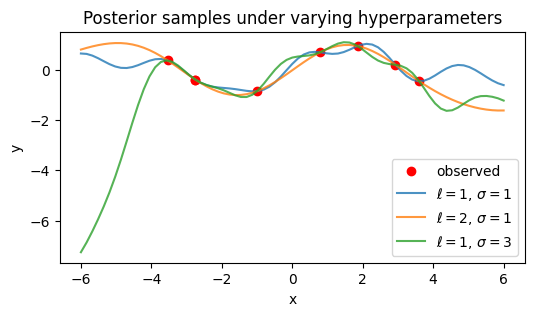

In [19]:
fig = plt.figure(figsize=(6, 3)) 
plt.plot(X1, y1, 'ro', label = 'observed')
plt.plot(X2, y2.T, alpha=0.8, label="$\\ell = 1$, $\\sigma = 1$")
plt.plot(X2, y3.T, alpha=0.8, label="$\\ell = 2$, $\\sigma = 1$")
plt.plot(X2, y4.T, alpha=0.8, label="$\\ell = 1$, $\\sigma = 3$")
plt.legend()
plt.title("Posterior samples under varying hyperparameters")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Posterior_sample.png', bbox_inches='tight')
plt.show()

In [20]:
f_best = y1.min()
def acq_EI(f_best, σ, μ):
    gamma = (f_best-μ)/σ
    return σ*(norm.cdf(gamma)*gamma+norm.pdf(gamma))

In [21]:
print(f_best)

-0.8434530842830913


In [22]:
acq_EI_M2 = acq_EI(f_best, σ2, μ2)
acq_EI_M3 = acq_EI(f_best, σ3, μ3)
acq_EI_M4 = acq_EI(f_best, σ4, μ4)

In [23]:
[np.max(acq_EI_M2), np.max(acq_EI_M3), np.max(acq_EI_M4)]

[0.16089642329493228, 0.29893469923417576, 0.8597419308195196]

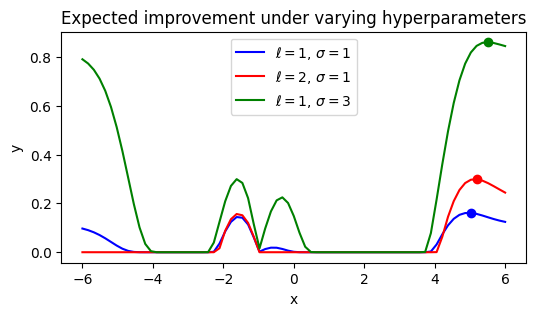

In [24]:
fig = plt.figure(figsize=(6, 3)) 
plt.plot(X2[np.argmax(acq_EI_M2)], np.max(acq_EI_M2), 'ob')
plt.plot(X2[np.argmax(acq_EI_M3)], np.max(acq_EI_M3), 'or')           
plt.plot(X2[np.argmax(acq_EI_M4)], np.max(acq_EI_M4), 'og')   
plt.plot(X2, acq_EI_M2, 'b', label="$\\ell = 1$, $\\sigma = 1$")
plt.plot(X2, acq_EI_M3, 'r', label="$\\ell = 2$, $\\sigma = 1$")
plt.plot(X2, acq_EI_M4, 'g', label="$\\ell = 1$, $\\sigma = 3$")
plt.legend()
plt.title("Expected improvement under varying hyperparameters")
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('EI.png', bbox_inches='tight')
plt.show()

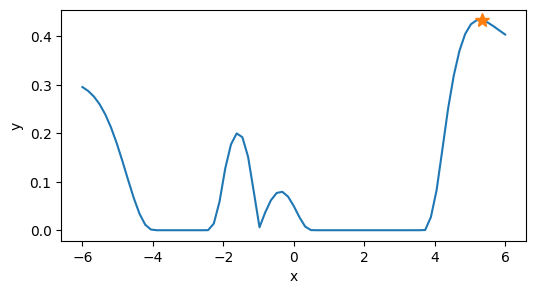

In [25]:
integrated_EI =  (acq_EI_M2+ acq_EI_M3+ acq_EI_M4)/3
fig = plt.figure(figsize=(6, 3)) 
plt.plot(X2, integrated_EI)
plt.plot(X2[np.argmax(integrated_EI)], np.max(integrated_EI), '*', ms=10) 
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('integrated_EI.png', bbox_inches='tight')
plt.show()

Code was adapted from https://peterroelants.github.io/posts/gaussian-process-tutorial/